# Basic GAN

使用 GAN 简单测试动漫头像的图片生成。

References:

+ [DCGAN TUTORIAL](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)
+ [Anime Face Dataset](https://www.kaggle.com/datasets/splcher/animefacedataset)

其它相关代码:

+ 数据集 mean 和 std 的计算
+ ConvTranspose2d 简单测试

In [2]:
import torch 
from torch import nn, Tensor 

In [3]:
# 参数配置
from dataclasses import dataclass


@dataclass
class HyperParameters:
    batch_size: int = 128

    # 图片相关的维度
    img_height: int = 64  # 等价于 行数 (如果修改这里的值, 需要修改 Generator 部分的代码)
    img_weight: int = 64  # 等价于 列数 (如果修改这里的值, 需要修改 Generator 部分的代码)
    img_channels: int = 3  # (如果修改这里的值, 需要修改一部分的代码)

    gen_input_dims: int = 100  # 生成器输入的维度
    data_path: str = "images"  # 图片数据所在的路径
    
    gen_feature_maps: int = 64  # 生成器 特征图 的数量, 也就是 kernel 的数量
    dis_feature_maps: int = 64  # 判别器 特征图 的数量, 也就是 kernel 的数量
    
    learning_rate: float = 2e-4
    num_epochs: int = 10


hparams = HyperParameters()

In [ ]:
# # 求数据集的 均值 和 标准差, 核心思想: 平均值求解是可以拆分的
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms

# # ImageFolder 方法的数据格式是: root 路径下一个 label 一个文件夹, 图片放在这些文件夹里面
# # 这个 label 对于 GAN 来说没有什么用途, 自己创建一个假的 label 文件夹即可
# dataset = datasets.ImageFolder(
#     root=hparams.data_path,
#     transform=transforms.Compose([
#         transforms.Resize(size=(hparams.img_height, hparams.img_weight)),  # 将图片统一到同一个尺寸
#         transforms.ToTensor(),  # 转换为张量, 并将取值范围从 [0, 255] 变成 [0, 1] 之间
#     ])
# )
# # Create the dataloader
# dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)
# mean_dims = [0, 2, 3]  # if hparams.img_channels == 3 else [0, 1, 2]

# # 求均值
# channel_means = torch.zeros(hparams.img_channels)

# for batch_imgs, _ in dataloader:
#     channel_means += torch.mean(batch_imgs, mean_dims)

# channel_means = channel_means / len(dataset)
# print("每一个通道的均值是", channel_means)

# # 求标准差
# channel_means = channel_means.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
# channel_stds = torch.zeros(hparams.img_channels)

# for batch_imgs, _ in dataloader:
#     channel_stds += torch.mean((batch_imgs - channel_means) ** 2, mean_dims)

# channel_stds = torch.sqrt(channel_stds / len(dataset))
# channel_means = channel_means.squeeze()
# print("每一个通道的标准差是", channel_stds)

In [4]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 初始化数据集, 数据加载器
dataset = datasets.ImageFolder(
    root=hparams.data_path,
    transform=transforms.Compose([
        transforms.Resize(size=(hparams.img_height, hparams.img_weight)),  # 将图片统一到同一个尺寸
        transforms.ToTensor(),  # 转换为张量, 并将取值范围从 [0, 255] 变成 [0, 1] 之间
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 将图像的取值范围从 [0, 1] 变成 [-1, 1] (注意, 不需要 z-score 化)
    ])
)

dataloader = DataLoader(dataset, batch_size=hparams.batch_size, shuffle=True, num_workers=2, drop_last=True)

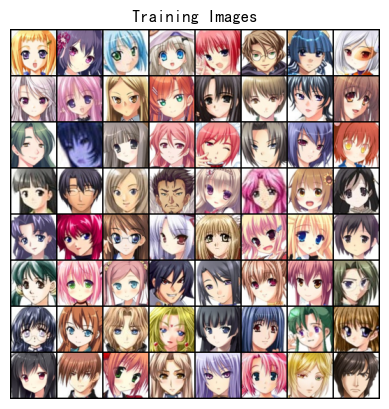

In [5]:
import matplotlib.pyplot as plt 
from torchvision import utils as vutils


# def un_normalize(imgs: Tensor):
#     imgs = imgs * channel_stds.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
#     imgs = imgs + channel_means.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
#     return imgs 


def show_images(imgs: Tensor, title_str: str = "Images"):
    # imgs = un_normalize(imgs)
    pics = vutils.make_grid(imgs, normalize=True).permute(1, 2, 0)
    
    plt.title(title_str)
    plt.axis("off")
    return plt.imshow(pics.numpy())


def save_images(imgs: Tensor, save_path: str):
    # imgs = un_normalize(imgs)
    vutils.save_image(imgs, save_path, normalize=True)


real_images, _ = next(iter(dataloader))


show_images(real_images[:64], "Training Images")

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # 输入: [batch_size, gen_input_dims, 1, 1]
            nn.ConvTranspose2d(  # 转置卷积: 将 卷积操作 中的 卷积矩阵 转置后进行计算, 相当于 上采样
                in_channels=hparams.gen_input_dims, 
                out_channels=hparams.gen_feature_maps * 8, 
                kernel_size=4, stride=1, padding=0, bias=False
            ),  # 输出: [batch_size, out_channels, 4, 4]
            nn.BatchNorm2d(hparams.gen_feature_maps * 8),  # DCGAN 的主要贡献
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=hparams.gen_feature_maps * 8,
                out_channels=hparams.gen_feature_maps * 4, 
                kernel_size=4, stride=2, padding=1, bias=False
            ),  # 输出: [batch_size, out_channels, 8, 8]
            nn.BatchNorm2d(hparams.gen_feature_maps * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=hparams.gen_feature_maps * 4,
                out_channels=hparams.gen_feature_maps * 2,
                kernel_size=4, stride=2, padding=1, bias=False
            ),  # 输出: [batch_size, out_channels, 16, 16]
            nn.BatchNorm2d(hparams.gen_feature_maps * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=hparams.gen_feature_maps * 2,
                out_channels=hparams.gen_feature_maps,
                kernel_size=4, stride=2, padding=1, bias=False
            ),  # 输出: [batch_size, out_channels, 32, 32]
            nn.BatchNorm2d(hparams.gen_feature_maps),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=hparams.gen_feature_maps,
                out_channels=hparams.img_channels,
                kernel_size=4, stride=2, padding=1, bias=False
            ),  # 输出: [batch_size, out_channels, 64, 64]
            nn.Tanh()  # 取值范围在 [-1, 1] 之间
        )

    def forward(self, input: Tensor):
        # # 输入的样式
        # input = torch.randn(hparams.batch_size, hparams.gen_input_dims, 1, 1, device=next(self.parameters).device)
        return self.main(input)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(
                in_channels=hparams.img_channels, 
                out_channels=hparams.dis_feature_maps, 
                kernel_size=4, stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                in_channels=hparams.dis_feature_maps, 
                out_channels=hparams.dis_feature_maps * 2, 
                kernel_size=4, stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(hparams.dis_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                in_channels=hparams.dis_feature_maps * 2, 
                out_channels=hparams.dis_feature_maps * 4, 
                kernel_size=4, stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(hparams.dis_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                in_channels=hparams.dis_feature_maps * 4, 
                out_channels=hparams.dis_feature_maps * 8, 
                kernel_size=4, stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(hparams.dis_feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                in_channels=hparams.dis_feature_maps * 8, 
                out_channels=1, kernel_size=4, stride=1, padding=0, bias=False
            ),
            # nn.Sigmoid()
        )

    def forward(self, input: Tensor):
        return self.main(input)

In [8]:
def weights_init(module: nn.Module):
    classname = module.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(module.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(module.weight.data, 1.0, 0.02)
        nn.init.constant_(module.bias.data, 0)

generator = Generator()
generator.apply(weights_init)
print(generator)

discriminator = Discriminator()
discriminator.apply(weights_init)
print(discriminator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [9]:
from tqdm import tqdm

from torch import optim

gen_loss_list = []
dis_loss_list = []

gen_imgs_probs = []
dis_pos_imgs_probs = []
dis_neg_imgs_probs = []

eval_gen_inputs = torch.randn(64, hparams.gen_input_dims, 1, 1)

eval_img_list = []

device = torch.device("cuda:0")

loss_fn = nn.BCEWithLogitsLoss()

generator.to(device)
discriminator.to(device)
gen_optimizer = optim.Adam(generator.parameters(), lr=hparams.learning_rate, betas=(0.5, 0.999))
dis_optimizer = optim.Adam(discriminator.parameters(), lr=hparams.learning_rate, betas=(0.5, 0.999))

def update_discriminator(batch_imgs, method="nsgan"):
    dis_optimizer.zero_grad()
    
    batch_size = batch_imgs.size(0)
    
    # 真实的图片
    dis_output1 = discriminator(batch_imgs.to(device)).squeeze()
    dis_loss1 = loss_fn(
        dis_output1, 
        torch.ones(batch_size).to(device)
    )

    # 生成器生成的图片
    dis_output2 = discriminator(
        generator(
            torch.randn(batch_size, hparams.gen_input_dims, 1, 1).to(device)
        ).detach()
    ).squeeze()
    dis_loss2 = loss_fn(
        dis_output2, 
        torch.zeros(batch_size).to(device)
    )

    dis_loss = (dis_loss1 + dis_loss2) / 2
    
    if method != "mmgan":
        dis_loss = dis_loss / 20  # 缩小学习率 !!!
    
    dis_loss.backward()
    dis_optimizer.step()
    
    dis_loss_list.append(dis_loss.detach().item())
    dis_pos_imgs_probs.append(torch.sigmoid(dis_output1.detach()).mean().item())
    dis_neg_imgs_probs.append(torch.sigmoid(dis_output2.detach()).mean().item())

def update_generator(method="nsgan"):
    gen_optimizer.zero_grad()
    gen_output = discriminator(
        generator(
            torch.randn(hparams.batch_size, hparams.gen_input_dims, 1, 1).to(device)
        )
    ).squeeze()
    
    if method == "nsgan":
        gen_loss = loss_fn(
            gen_output, 
            torch.ones(hparams.batch_size).to(device)
        )
    elif method == "mmgan":
        gen_loss = - loss_fn(
            gen_output, 
            torch.zeros(hparams.batch_size).to(device)
        ) * 100  # 扩大学习率
        
    else:
        raise ValueError
    
    gen_loss.backward()
    gen_optimizer.step()
    
    gen_loss_list.append(gen_loss.detach().item())
    gen_imgs_probs.append(torch.sigmoid(gen_output.detach()).mean().item())

def eval():
    generator.eval()

    with torch.no_grad():
        gen_imgs = generator(eval_gen_inputs.to(device)).detach()
    
    generator.train()
    
    eval_img_list.append(gen_imgs)

total_steps = hparams.num_epochs * len(dataloader)
pbar = tqdm(total=total_steps)

for epoch in range(hparams.num_epochs):
    
    for step, (batch_imgs, _) in enumerate(dataloader):
        
        pbar.update(1) 
        
        # 更新 判别器 模型
        update_discriminator(batch_imgs, "nsgan")
        
        update_generator("nsgan")
        
        if (step % 500 == 0) or ((epoch == hparams.num_epochs - 1) and (step == len(dataloader) - 1)):
            eval()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 4956/4960 [01:06<00:00, 75.69it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4960/4960 [01:20<00:00, 75.69it/s]

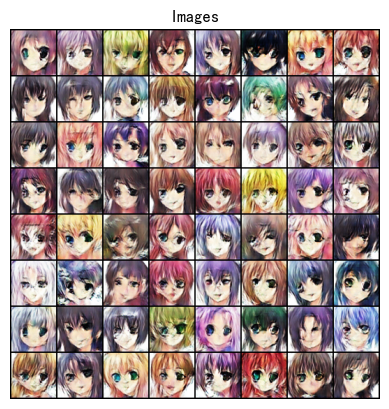

In [10]:
show_images(eval_img_list[-1].cpu())

In [11]:
save_images(eval_img_list[-1].cpu(), "basic_gan.png")

In [ ]:
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure(figsize=(6, 6))
plt.axis("off")
draw_objs = [
    [plt.imshow(
        vutils.make_grid(imgs.cpu(), normalize=True).permute(1, 2, 0), animated=True
    ), ] for imgs in eval_img_list
]
ani = animation.ArtistAnimation(fig, draw_objs, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

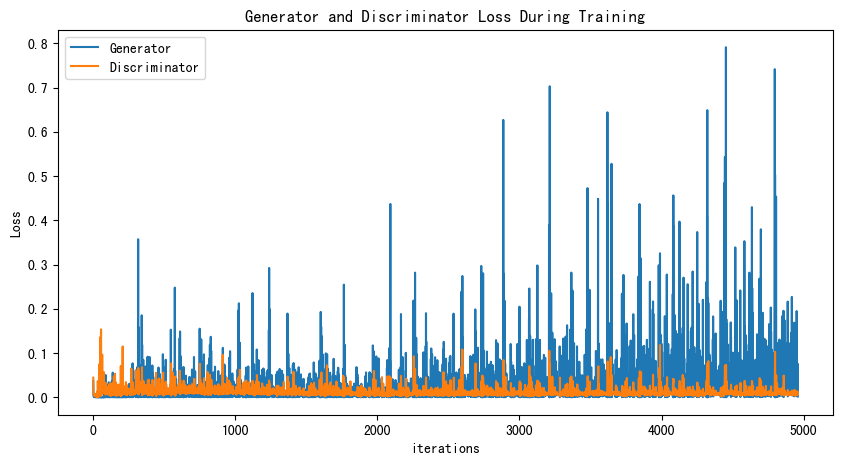

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_imgs_probs,label="Generator")
plt.plot(dis_loss_list,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

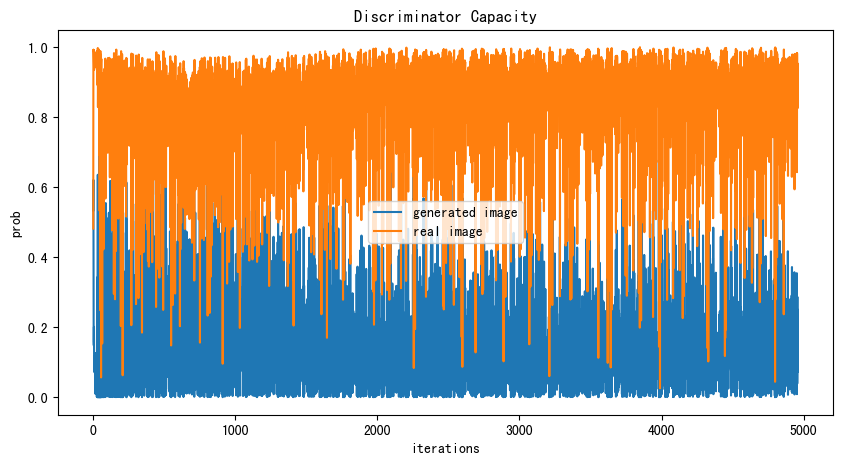

In [13]:
plt.figure(figsize=(10,5))
plt.title("Discriminator Capacity")
plt.plot(dis_neg_imgs_probs,label="generated image")
plt.plot(dis_pos_imgs_probs,label="real image")
plt.xlabel("iterations")
plt.ylabel("prob")
plt.legend()
plt.show()

# Transpose Convolution

先复习一下 [二维卷积](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) 相关的知识:

PyTorch 中的实现包含了 空洞卷积 (dilated convolution) 和 分组卷积 (group convolution), 这里暂时不考虑。

深度学习中的卷积计算在信号处理领域应该叫 [互相关](https://en.wikipedia.org/wiki/Cross-correlation) (cross-correlation), 也被称为 sliding dot product。从此可以看出, 整个运算分为两个部分: **滑窗** 和 **点乘**。

如果图片的宽度是 img_width, 那么用一个长为 kernel_width 的窗口去滑动, 可以滑出 img_width - kernel_width + 1 个结果。

如果希望滑动的结果和图片的宽度保持一致, 那么就需要 padding。一般情况下, 我们会在图片的左右补同样个数的 0。因此, kernel_width 一般为 奇数, 当 kernel_width=3, padding_width=1, 当 kernel_width=5, padding_width=2, 大体上是这样。

stride 表示步长, 如果 stride=2, 也就意味着将原来的偶数位的 窗口结果 给丢弃掉。此时, 如果希望 img_width 和 窗口结果 相同, 那是不可能的!

最终的窗口数为: (img_width + 2 * padding_width - kernel_width) / stride + 1。


对于卷积来说, 输入像素宽度是 img_width, 输出的像素宽度是 img_width - kernel_width + 1。由于输出的像素宽度小于输入的像素宽度, 被称为 下采样, 少了 kernel_width - 1 个像素宽度。如果希望输入的像素宽度和输出的像素宽度一致, 那么需要左右补 (kernel_width - 1) / 2 个零。

对于转置卷积来说, 我们希望的是上采样, 即输出的像素宽度大于输入的像素宽度, 多 kernel_width + 1 个像素宽度。此时就需要左右补 (kernel_width - 1) 个零。

在卷积中, padding_width 表示的是额外补零的个数, 在转置卷积中, padding_width 表示的是减少补零的个数。

在数据科学中, **样本** 对应 **行**, **特征** 对应 **列**。
在图片矩阵中, **高** 对应 **行**, **宽** 对应 **列** (不理解画个图即可)。**channels** 对应 **特征**, shape 是: `[n_channels, img_height, img_width]` 。

### References

+ [How was conv2d implemented in pytorch?](https://discuss.pytorch.org/t/how-was-conv2d-implemented-in-pytorch/35223/5)
+ [ConvTranspose2d using unfold](https://discuss.pytorch.org/t/convtranspose2d-using-unfold/120350/2)
+ [What is Transposed Convolutional Layer?](https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11)
+ [CONVTRANSPOSE2D](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)

In [ ]:
import warnings 

import torch 
from torch import nn, Tensor
from torch.nn import functional as F

def conv2d_fold_unfold(
    input: Tensor, weight: Tensor, bias=None, 
    stride_h: int = 1, stride_w: int = 1, 
    padding_h: int = 0, padding_w: int = 0
):

    # ## step1: 参数检查, 计算维度
    if input.ndim != 4:
        raise ValueError("input 张量必须是四维数组")
    if weight.ndim != 4:
        raise ValueError("weight 张量必须是四维数组")
    if bias.ndim != 1:
        raise ValueError("bias 张量必须是一维数组")
    
    batch_size, in_channels, img_h, img_w = input.shape 
    out_channels, _, kernel_h, kernel_w = weight.shape
    
    if bias.size(0) != out_channels:
        raise ValueError("weight 张量和 bias 张量的维度不匹配")
    if weight.size(1) != in_channels:
        raise ValueError("weight 张量和 input 张量的维度不匹配")
    if kernel_h % 2 == 0:
        warnings.warn("kernel 的高一般是奇数, 不是偶数")
    if kernel_w % 2 == 0:
        warnings.warn("kernel 的宽一般是奇数, 不是偶数")
        
    if (img_h + 2 * padding_h - kernel_h) % stride_h != 0:
        warnings.warn("stride_h 的设置不是很合理")
    if (img_w + 2 * padding_w - kernel_w) % stride_w != 0:
        warnings.warn("stride_w 的设置不是很合理")
    
    output_h = int((img_h + 2 * padding_h - kernel_h) / stride_h) + 1
    output_w = int((img_w + 2 * padding_w - kernel_w) / stride_w) + 1

    # ## step2: padding
    input = F.pad(
        input, mode="constant", value=0.,
        pad=(padding_w, padding_w, padding_h, padding_h),  # 从后往前
    )

    # ## step3: im2col (image -> columns)
    # 每一个感受野有 in_channels * kernel_h * kernel_w 个特征, 一共有 n_regions 个感受野
    # 一个感受野对应一个数字 (下采样), 输出图片的特征由 n_regions 决定
    # conv_matrix's shape: [batch_size, kernel_h * kernel_w * in_channels, n_regions]
    conv_matrix = F.unfold(
        input, kernel_size=(kernel_h, kernel_w), stride=(stride_h, stride_w)
    )
    
    # ## step4: 矩阵计算
    # output's shape: [batch_size, n_regions, out_channels]
    output = conv_matrix.transpose(1, 2) @ weight.reshape(out_channels, -1).transpose(0, 1) + bias
    output = output.transpose(1, 2)
    
    # ## step5: col2im (columns -> image)
    # fold 是 unfold 的反操作, 注意写法
    output = F.fold(output, output_size=(output_h, output_w), kernel_size=(1, 1))

    return output  


def is_same_tensor(t1: Tensor, t2: Tensor, eps: float = 1e-5) -> bool:
    return torch.abs(t1 - t2).max().item() < eps


@torch.no_grad()
def test_conv2d_fold_unfold():
    conv2d_module = nn.Conv2d(
        in_channels=10, out_channels=20, 
        kernel_size=(3, 5), stride=(2, 2), padding=(2, 4)
    ).eval()
    
    test_input = torch.randn(3, 10, 64, 64)
    
    gold_output = conv2d_module.forward(test_input)
    test_output = conv2d_fold_unfold(test_input, conv2d_module.weight, conv2d_module.bias, 2, 2, 2, 4)
    
    print(gold_output.shape, test_output.shape)
    print(is_same_tensor(gold_output, test_output))


test_conv2d_fold_unfold()

In [ ]:
import warnings 

import torch 
from torch import nn, Tensor
from torch.nn import functional as F

def tran_conv2d_fold_unfold(
    input: Tensor, weight: Tensor, bias=None, 
    padding_h: int = 0, padding_w: int = 0
):

    batch_size, in_channels, img_h, img_w = input.shape 
    out_channels, _, kernel_h, kernel_w = weight.shape
    
    conv_padding_w = kernel_w - padding_w - 1
    conv_padding_h = kernel_h - padding_h - 1
    
    return conv2d_fold_unfold(
        input, torch.rot90(weight, k=2, dims=[2, 3]).transpose(0, 1), bias, 
        stride_h=1, stride_w=1, 
        padding_h=conv_padding_h, padding_w=conv_padding_w
    )


def is_same_tensor(t1: Tensor, t2: Tensor, eps: float = 1e-5) -> bool:
    return torch.abs(t1 - t2).max().item() < eps


@torch.no_grad()
def test_tran_conv2d_fold_unfold():
    tran_conv2d_module = nn.ConvTranspose2d(
        in_channels=10, out_channels=20, 
        kernel_size=(3, 5), padding=(1, 1)
    ).eval()
    
    test_input = torch.randn(3, 10, 64, 64)

    gold_output = tran_conv2d_module.forward(test_input)
    test_output = tran_conv2d_fold_unfold(test_input, tran_conv2d_module.weight, tran_conv2d_module.bias, 1, 1)
    
    print(gold_output.shape, test_output.shape)
    print(is_same_tensor(gold_output, test_output))


test_tran_conv2d_fold_unfold()